In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sparse
import h5py
import os

# Load file, the cortex model of voxel level

In [2]:
file = h5py.File("raw_data/NSR_data_May22.mat", "r")
dti = file["NSR_dti_net_full"][:]  # voxel to voxoel
gm = file["NSR_dti_grey_matter"][:].squeeze()  # gray matter at voxel level
synapse_scale = file["NSR_voxel_Synapsis"][:].squeeze()  # synapse scale at voxel level
brain_parts = file['NSR_dti_brainpart'][:].squeeze() # cortex + sub-cortex
hpc_label = file["NSR_dti_HCPex_label"][:].squeeze()
index_cor = np.where(brain_parts==1)[0]

# if we only consider cortex
# dti = dti[index_cor, :]
# dti = dti[:, index_cor]
# nonzero = np.where(dti.sum(axis=1)>0)[0]
# dti = dti[nonzero, :]
# dti = dti[:, nonzero]
# dti[dti>1400] = 1400  # for avoiding large numbers in dti
# index = index_cor[nonzero]
# conn = dti / dti.sum(axis=1, keepdims=True)
# conn = sparse.COO(conn)
# dti = sparse.COO(dti)
# gm = gm[index]
# hpc_label = hpc_label[index]
# synapse_scale = synapse_scale[index]

assert (dti.sum(axis=1) >0).all()
conn = dti / dti.sum(axis=1, keepdims=True)
conn = sparse.COO(conn)
dti = sparse.COO(dti)

num_voxel = gm.shape[0]
print("density", dti.density)
print("size", gm.shape[0])

density 0.01733077658909178
size 16043


In [3]:
file.keys()

<KeysViewHDF5 ['NSR_Auditory_Task', 'NSR_Resting_state', 'NSR_Visual_Task', 'NSR_dti_HCPex_label', 'NSR_dti_brainpart', 'NSR_dti_grey_matter', 'NSR_dti_label_num', 'NSR_dti_net_full', 'NSR_voxel_Synapsis', 'NSR_voxel_xyz']>

In [5]:
file["NSR_dti_label_num"][:]


array([[ 5277.,  5290.,  5305., ..., 51478., 51524., 51569.]])

Text(0.5, 0, 'dti_row_sum')

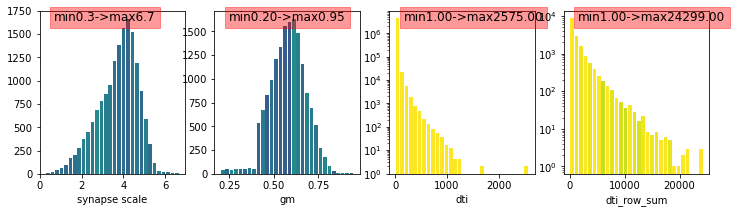

In [14]:
cmap = plt.cm.viridis_r
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
ax = ax.flatten()
cnts, values, bars = ax[0].hist(synapse_scale, bins=30, rwidth=0.8, log=False)
newvalue = (synapse_scale - synapse_scale.min()) / (synapse_scale.max() - synapse_scale.min())
for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(cmap(newvalue[i]))
ax[0].text(0.1, 1.0, f"min{synapse_scale.min():.1f}->max{synapse_scale.max():.1f}", transform=ax[0].transAxes, va='top',fontsize=12,
          bbox={'color':'r','alpha':0.4,})
ax[0].set_xlabel("synapse scale")

cnts1, values1, bars1 = ax[1].hist(gm, bins=30, rwidth=0.8)
newvalue = (gm - gm.min()) / (gm.max() - gm.min())
for i, (cnt, value, bar) in enumerate(zip(cnts1, values1, bars1)):
    bar.set_facecolor(cmap(newvalue[i]))
ax[1].text(0.1, 1.0, f"min{gm.min():.2f}->max{gm.max():.2f}", transform=ax[1].transAxes, va='top',fontsize=12,
          bbox={'color':'r','alpha':0.4,})
ax[1].set_xlabel("gm")

cnts1, values1, bars1 = ax[2].hist(dti.data, bins=30, rwidth=0.8, log=True)
newvalue = (dti.data - dti.data.min()) / (dti.data.max() - dti.data.min())
for i, (cnt, value, bar) in enumerate(zip(cnts1, values1, bars1)):
    bar.set_facecolor(cmap(newvalue[i]))
ax[2].text(0.1, 1.0, f"min{dti.data.min():.2f}->max{dti.data.max():.2f}", transform=ax[2].transAxes, va='top',fontsize=12,
          bbox={'color':'r','alpha':0.4,})
ax[2].set_xlabel("dti")

dti_row_sum = dti.sum(axis=1)
dti_row_sum = dti_row_sum.data
dti_row_sum = dti_row_sum[~np.isnan(dti_row_sum)]
cnts1, values1, bars1 = ax[3].hist(dti_row_sum, bins=30, rwidth=0.8, log=True)
newvalue = (dti_row_sum - dti_row_sum.min()) / (dti_row_sum.max() - dti_row_sum.min())
for i, (cnt, value, bar) in enumerate(zip(cnts1, values1, bars1)):
    bar.set_facecolor(cmap(newvalue[i]))
ax[3].text(0.1, 1.0, f"min{dti_row_sum.min():.2f}->max{dti_row_sum.max():.2f}", transform=ax[3].transAxes, va='top',fontsize=12,
          bbox={'color':'r','alpha':0.4,})
ax[3].set_xlabel("dti_row_sum")

# Process to population level

## suppose:
- the same neuronal density among cortical voxels and thus number of neurons in each voxel is proportional to the gray matter.
- the synapse scale is the related correlation of total synapse to voxels.
- the local connectivity is wired according to the mciro-circuit, and the voxel-voxel connectivity is obeying the correlation as DTI.
- the inner/outer synapse for voxel of V1 is 2.8/1 (originated from 10*11 table of micro-circuit), and we can compute the outer ratio for other voxel $r_{j}$ by
$$\dfrac{syn_{v1} * r_{v1}}{syn_{j} * r_{j}}=\dfrac{\text{row sum}\,dti_{v1}}{\text{row sum}\,dti_{j}}$$

### The fourth point design has not been used

In [15]:
def _add_laminar_cortex_model(conn_prob, gm, synapse):
    """
    Process the connection probability matrix, grey matter and degree scale for DTB with pure voxel and micro-column
    structure.  Each voxel is split into 2 populations (E and I). Each micro-column is spilt into 10 populations
    (L1E, L1I, L2/3E, L2/3I, L4E, L4I, L5E, L5I, L6E, L6I).

    Parameters
    ----------
    conn_prob: numpy.ndarray, shape [N, N]
        the connectivity probability matrix between N voxels/micro-columns.

    gm: numpy.ndarray, shape [N]
        the normalized grey matter in each voxel/micro-column.

    canonical_voxel: bool
        Ture for voxel structure; False for micro-column structure.

    Returns
    -------
    out_conn_prob: numpy.ndarray
        connectivity probability matrix between populations (shape [2*N, 2*N] for voxel; shape[10*N, 10*N] for micro
        -column) in the sparse matrix form.

    out_gm: numpy.ndarray
        grey matter for populations in DTB (shape [2*N] for voxel; shape[10*N] for micro-column).

    out_degree_scale: numpy.ndarray
        scale of degree for populations in DTB (shape [2*N] for voxel; shape[10*N] for micro-column).

    """
    lcm_connect_prob = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 3554, 804, 881, 45, 431, 0, 136, 0, 1020],
                                 [0, 0, 1778, 532, 456, 29, 217, 0, 69, 0, 396],
                                 [0, 0, 417, 84, 1070, 690, 79, 93, 1686, 0, 1489],
                                 [0, 0, 168, 41, 628, 538, 36, 0, 1028, 0, 790],
                                 [0, 0, 2550, 176, 765, 99, 621, 596, 363, 7, 1591],
                                 [0, 0, 1357, 76, 380, 32, 375, 403, 129, 0, 214],
                                 [0, 0, 643, 46, 549, 196, 327, 126, 925, 597, 2609],
                                 [0, 0, 80, 8, 92, 3, 159, 11, 76, 499, 1794]], dtype=np.float64
                                )

    lcm_gm = np.array([0, 0,
                       33.8 * 78, 33.8 * 22,
                       34.9 * 80, 34.9 * 20,
                       7.6 * 82, 7.6 * 18,
                       22.1 * 83, 22.1 * 17], dtype=np.float64)  # ignore the L1 neurons
    with np.errstate(divide='ignore', invalid='ignore'):
        lcm_connect_prob = lcm_connect_prob * lcm_gm[:, None]
        lcm_gm = lcm_gm / lcm_gm.sum()
    weight = lcm_gm[::2]
    weight = weight / weight.sum(axis=0)
    weight = np.broadcast_to(weight, (conn_prob.data.shape[0], 5))


    lcm_connect_prob = lcm_connect_prob / np.sum(lcm_connect_prob)
    degree_scale = lcm_connect_prob.sum(axis=1) / lcm_connect_prob.sum()
    degree_scale = synapse[:, None] * degree_scale[None, :]
    degree_scale = degree_scale.reshape(-1)

    corrds1 = np.empty(
        [4, conn_prob.coords.shape[1] * lcm_connect_prob.shape[0] * int(lcm_connect_prob.shape[0] / 2)],
        dtype=np.int64)
    corrds1[3, :] = np.tile(np.repeat(np.arange(0, lcm_connect_prob.shape[0], 2), lcm_connect_prob.shape[0]),
                            conn_prob.coords.shape[1]).reshape([1, -1])

    corrds1[(0, 2), :] = np.broadcast_to(conn_prob.coords[:, :, None],
                                         [2, conn_prob.coords.shape[1],
                                          lcm_connect_prob.shape[0] * int(lcm_connect_prob.shape[0] / 2)]).reshape(
        [2, -1])
    corrds1[(1), :] = np.broadcast_to(np.arange(lcm_connect_prob.shape[0], dtype=np.int64)[None, :],
                                      [conn_prob.coords.shape[1] * int(lcm_connect_prob.shape[0] / 2),
                                       lcm_connect_prob.shape[0]]).reshape([1, -1])

    data1 = conn_prob.data[:, None] * lcm_connect_prob[:, -1]
    data1 = (data1[:, None, :] * weight[:, :, None]).reshape([-1])

    lcm_connect_prob_inner = sparse.COO(lcm_connect_prob[:, :-1])
    corrds2 = np.empty([4, conn_prob.shape[0] * lcm_connect_prob_inner.data.shape[0]], dtype=np.int64)
    corrds2[0, :] = np.broadcast_to(np.arange(conn_prob.shape[0], dtype=np.int64)[:, None],
                                    [conn_prob.shape[0], lcm_connect_prob_inner.data.shape[0]]).reshape([-1])
    corrds2[2, :] = corrds2[0, :]
    corrds2[(1, 3), :] = np.broadcast_to(lcm_connect_prob_inner.coords[:, None, :],
                                         [2, conn_prob.shape[0], lcm_connect_prob_inner.coords.shape[1]]).reshape(
        [2, -1])
    data2 = np.reshape(np.broadcast_to(lcm_connect_prob_inner.data[None, :], (conn_prob.shape[0], lcm_connect_prob_inner.data.shape[0])), [-1])

    coords = np.concatenate([corrds1, corrds2, ], axis=1)
    data = np.concatenate([data1, data2], axis=0)
    shape = [conn_prob.shape[0], lcm_connect_prob.shape[0], conn_prob.shape[1],
             lcm_connect_prob.shape[1] - 1]

    index = np.where(data)[0]
    print(f"process zero value in conn_prob {len(data)}-->{len(index)}")
    coords = coords[:, index]
    data = data[index]

    out_conn_prob = sparse.COO(coords=coords, data=data, shape=shape)
    out_conn_prob = out_conn_prob.reshape((conn_prob.shape[0] * lcm_connect_prob.shape[0],
                                           conn_prob.shape[1] * (lcm_connect_prob.shape[1] - 1)))

    gm /= gm.sum()
    out_gm = (gm[:, None] * lcm_gm[None, :]).reshape([-1])

    return out_conn_prob, out_gm, degree_scale

In [22]:
def _add_laminar_cortex_include_subcortical_in_whole_brain(conn_prob, gm, synapse_scale, brain_parts=None):
    cortical = np.where(brain_parts==1)[0]
    sub_cortical = np.where(brain_parts==2)[0]

    lcm_connect_prob = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 3554, 804, 881, 45, 431, 0, 136, 0, 1020],
                                 [0, 0, 1778, 532, 456, 29, 217, 0, 69, 0, 396],
                                 [0, 0, 417, 84, 1070, 690, 79, 93, 1686, 0, 1489],
                                 [0, 0, 168, 41, 628, 538, 36, 0, 1028, 0, 790],
                                 [0, 0, 2550, 176, 765, 99, 621, 596, 363, 7, 1591],
                                 [0, 0, 1357, 76, 380, 32, 375, 403, 129, 0, 214],
                                 [0, 0, 643, 46, 549, 196, 327, 126, 925, 597, 2609],
                                 [0, 0, 80, 8, 92, 3, 159, 11, 76, 499, 1794]], dtype=np.float64
                                )

    # wenyong setting (0.3, 0.2, 0.5), cortical column is (4/7, 1/7, 2/7)
    lcm_connect_prob_subcortical = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                             [0, 0, 0, 0, 0, 0, 0.6, 0.15, 0, 0, 0.25],
                                             [0, 0, 0, 0, 0, 0, 0.6, 0.15, 0, 0, 0.25],
                                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                             [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                                             ], dtype=np.float64)

    lcm_gm = np.array([0, 0,
                       33.8 * 78, 33.8 * 22,
                       34.9 * 80, 34.9 * 20,
                       7.6 * 82, 7.6 * 18,
                       22.1 * 83, 22.1 * 17], dtype=np.float64)  # ignore the L1 neurons
    lcm_gm /= lcm_gm.sum()

    weight = lcm_gm[::2]
    weight = weight / weight.sum(axis=0)
    weight = np.broadcast_to(weight, (cortical.shape[0], 5))

    with np.errstate(divide='ignore', invalid='ignore'):
        syna_nums_in_lcm = lcm_connect_prob.sum(1) * lcm_gm
        lcm_degree_scale = syna_nums_in_lcm / syna_nums_in_lcm.sum() / lcm_gm
        lcm_degree_scale = np.where(np.isnan(lcm_degree_scale), 0, lcm_degree_scale)
        lcm_connect_prob /= lcm_connect_prob.sum(axis=1, keepdims=True)
        lcm_connect_prob = np.where(np.isnan(lcm_connect_prob), 0, lcm_connect_prob)

    out_degree_scale = (lcm_degree_scale[None, :] * synapse_scale[:, None]).reshape(-1)

    if isinstance(conn_prob, np.ndarray):
        with np.errstate(divide='ignore', invalid='ignore'):
            conn_prob[np.diag_indices(conn_prob.shape[0])] = 0
            conn_prob = conn_prob / conn_prob.sum(axis=1, keepdims=True)
        conn_prob[np.isnan(conn_prob)] = 0
        N = len(conn_prob)
        conn_prob = sparse.COO(conn_prob)
    else:
        N = conn_prob.shape[0]

    assert N == cortical.shape[0] + sub_cortical.shape[0]
    gm = gm / gm.sum()
    out_gm = (gm[:, None] * lcm_gm[None, :]).reshape(
        [-1])  # shape[cortical_voxel, 10] reshape to [10 * cortical_voxel]
    for i in sub_cortical:
        out_gm[10 * i:10 * (i + 1)] = 0.
        out_gm[10 * i + 6] = gm[i] * 0.8
        out_gm[10 * i + 7] = gm[i] * 0.2
    weight_part = np.array([0., 0., 0., 1., 0.])
    weight_part = np.broadcast_to(weight_part, (sub_cortical.shape[0], 5))

    weight = np.concatenate([weight, weight_part], axis=0)

    for i in sub_cortical:
        out_degree_scale[10 * i:10 * (i + 1)] = 0.
        out_degree_scale[10 * i + 6] = synapse_scale[i] * 1.
        out_degree_scale[10 * i + 7] = synapse_scale[i] * 1.

    """
    deal with outer_connection of cortical voxel
    """

    index_cortical = np.in1d(conn_prob.coords[0], cortical)
    coords_cortical = conn_prob.coords[:, index_cortical]
    index_exclude = coords_cortical[0] != coords_cortical[1]
    coords_cortical = coords_cortical[:, index_exclude]
    index_cortical = np.where(index_cortical)[0][index_exclude]
    corrds1 = np.empty(
        [4, coords_cortical.shape[1] * lcm_connect_prob.shape[0] * int(lcm_connect_prob.shape[0] / 2)],
        dtype=np.int64)  # 5 denotes:L1E, L2/3E, L4E, L5E, L6E

    corrds1[3, :] = np.tile(np.repeat(np.arange(0, lcm_connect_prob.shape[0], 2), lcm_connect_prob.shape[0]),
                            coords_cortical.shape[1]).reshape([1, -1])
    corrds1[(0, 2), :] = np.broadcast_to(coords_cortical[:, :, None],
                                         [2, coords_cortical.shape[1],
                                          lcm_connect_prob.shape[0] * int(lcm_connect_prob.shape[0] / 2)]).reshape(
        [2, -1])
    corrds1[(1), :] = np.broadcast_to(np.arange(lcm_connect_prob.shape[0], dtype=np.int64)[None, :],
                                      [coords_cortical.shape[1] * int(lcm_connect_prob.shape[0] / 2),
                                       lcm_connect_prob.shape[0]]).reshape([1, -1])
    data1 = conn_prob.data[index_cortical, None] * lcm_connect_prob[:, -1]
    data1 = (data1[:, None, :] * weight[(coords_cortical[1]), :, None]).reshape([-1])

    """
    deal with outer_connection of subcortical voxel
    """
    index_subcortical = np.in1d(conn_prob.coords[0], sub_cortical)
    coords_subcortical = conn_prob.coords[:, index_subcortical]
    index_exclude = coords_subcortical[0] == coords_subcortical[
        1]  # empty [], because diagonal matrix is zero in conn_prob
    assert sum(index_exclude) == 0
    coords3 = np.empty([4, coords_subcortical.shape[1] * 2 * int(lcm_connect_prob.shape[0] / 2)], dtype=np.int64)
    coords3[3, :] = np.tile(np.repeat(np.arange(0, lcm_connect_prob.shape[0], 2), 2),
                            coords_subcortical.shape[1]).reshape([1, -1])
    coords3[(0, 2), :] = np.broadcast_to(coords_subcortical[:, :, None],
                                         [2, coords_subcortical.shape[1],
                                          2 * int(lcm_connect_prob.shape[0] / 2)]).reshape([2, -1])
    coords3[(1), :] = np.broadcast_to(np.arange(6, 8, dtype=np.int64)[None, :],
                                      [coords_subcortical.shape[1] * int(lcm_connect_prob.shape[0] / 2),
                                       2]).reshape(
        [1, -1])
    index_sub = np.in1d(conn_prob.coords[0], sub_cortical)

    data3 = conn_prob.data[index_sub, None] * lcm_connect_prob_subcortical[6:8, -1]
    data3 = (data3[:, None, :] * weight[(coords_subcortical[1]), :, None]).reshape([-1])

    """
    deal with inner_connection of cortical voxel
    """
    lcm_connect_prob_inner = sparse.COO(lcm_connect_prob[:, :-1])
    corrds2 = np.empty([4, cortical.shape[0] * lcm_connect_prob_inner.data.shape[0]], dtype=np.int64)
    corrds2[0, :] = np.broadcast_to(cortical[:, None],
                                    [cortical.shape[0], lcm_connect_prob_inner.data.shape[0]]).reshape([-1])
    corrds2[2, :] = corrds2[0, :]
    corrds2[(1, 3), :] = np.broadcast_to(lcm_connect_prob_inner.coords[:, None, :],
                                         [2, cortical.shape[0], lcm_connect_prob_inner.coords.shape[1]]).reshape(
        [2, -1])
    data2 = np.broadcast_to(lcm_connect_prob_inner.data[None, :],
                            [cortical.shape[0], lcm_connect_prob_inner.coords.shape[1]]).reshape([-1])

    """
    deal with inner_connection of subcortical voxel
    """
    lcm_connect_prob_inner_subcortical = sparse.COO(lcm_connect_prob_subcortical[:, :-1])
    corrds4 = np.empty([4, sub_cortical.shape[0] * lcm_connect_prob_inner_subcortical.data.shape[0]],
                           dtype=np.int64)
    corrds4[0, :] = np.broadcast_to(sub_cortical[:, None],
                                        [sub_cortical.shape[0],
                                         lcm_connect_prob_inner_subcortical.data.shape[0]]).reshape(
        [-1])
    corrds4[2, :] = corrds4[0, :]
    corrds4[(1, 3), :] = np.broadcast_to(lcm_connect_prob_inner_subcortical.coords[:, None, :],
                                             [2, sub_cortical.shape[0],
                                              lcm_connect_prob_inner_subcortical.coords.shape[1]]).reshape(
        [2, -1])
    data4 = np.broadcast_to(lcm_connect_prob_inner_subcortical.data[None, :],
                                [sub_cortical.shape[0],
                                 lcm_connect_prob_inner_subcortical.coords.shape[1]]).reshape(
        [-1])

    coords = np.concatenate([corrds1, corrds2, coords3, corrds4], axis=1)
    data = np.concatenate([data1, data2, data3, data4], axis=0)
    index = np.where(data)[0]
    print(f"process zero value in conn_prob {len(data)}-->{len(index)}")
    coords = coords[:, index]
    data = data[index]
    shape = [conn_prob.shape[0], lcm_connect_prob.shape[0], conn_prob.shape[1],
             lcm_connect_prob.shape[1] - 1]
    out_conn_prob = sparse.COO(coords=coords, data=data, shape=shape)

    out_conn_prob = out_conn_prob.reshape((conn_prob.shape[0] * lcm_connect_prob.shape[0],
                                           conn_prob.shape[1] * (lcm_connect_prob.shape[1] - 1)))
    if conn_prob.shape[0] == 1:
        out_conn_prob = out_conn_prob / out_conn_prob.sum(axis=1, keepdims=True)
    return out_conn_prob, out_gm, out_degree_scale

In [3]:
v1_index = np.where(hpc_label==181)[0]
v1_synapse_scale = synapse_scale[v1_index].mean()
# suppose v1 synapse is 100, then we assign number of synapse to all voxel
synapse_scale = synapse_scale / v1_synapse_scale  # relative ratio of synapse scale
print(synapse_scale)
print(synapse_scale[:10])
print(synapse_scale[-10:])
degree_voxel = 100 * synapse_scale

[1.09630506 0.99055206 1.0880498  ... 0.17851233 0.12915402 0.08590899]
[1.09630506 0.99055206 1.0880498  1.05871962 1.08559191 1.10163605
 1.05567709 1.02360976 0.96676675 0.94891165]
[0.23084637 0.23516016 0.27453202 0.22842564 0.28496552 0.20876866
 0.26680689 0.17851233 0.12915402 0.08590899]


In [23]:
degree = 100
scale = int(5e8)

v1_index = np.where(hpc_label==181)[0]
v1_synapse_scale = synapse_scale[v1_index].mean()
# suppose v1 synapse is 100, then we assign number of synapse to all voxel
synapse_scale = synapse_scale / v1_synapse_scale  # relative ratio of synapse scale

# conn_prob means the correlation of total degree of a population, similar for synapse_scale.
pop_conn_prob, pop_block_size, pop_synapse_scale = _add_laminar_cortex_include_subcortical_in_whole_brain(conn, gm, synapse_scale, brain_parts)

popu_size = (pop_block_size * scale).astype(np.int32)
voxel_size = popu_size.reshape((-1, 10)).sum(axis=1)

degree_voxel = degree * synapse_scale
degree_popu = pop_synapse_scale * degree
assert abs((degree_popu[:10] * pop_block_size[:10]).sum() / pop_block_size[:10].sum() - degree_voxel[0]) < 1e-4
assert abs((degree_popu[-10:] * pop_block_size[-10:]).sum() / pop_block_size[-10:].sum() - degree_voxel[-1]) < 1e-4

print("degree population")
print(degree_popu[:10])
print(degree_popu[10:20])

fig, ax= plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()

for idx, value in enumerate([voxel_size, popu_size, degree_voxel, degree_popu]):
    value = value[value>0]
    cnts, values, bars = ax[idx].hist(value, bins=30, rwidth=0.8)
    newvalue = (value - value.min()) / (value.max() - value.min())
    for i, (cnt, value_data, bar) in enumerate(zip(cnts, values, bars)):
        bar.set_facecolor(cmap(newvalue[i]))
    ax[idx].text(0.1, 1.0, f"min{int(value.min())}->max{int(value.max())}", transform=ax[idx].transAxes, va='top',fontsize=12,
              bbox={'color':'r','alpha':0.4,})
ax[0].set_xlabel("voxel size")
ax[1].set_xlabel("population size")
ax[2].set_xlabel("voxel degree")
ax[3].set_xlabel("population degree")

process zero value in conn_prob 203706548-->122075380


MemoryError: Unable to allocate 3.64 GiB for an array with shape (122075380, 4) and data type int64

In [16]:
import pandas as pd
reader = pd.read_csv(
    r"E:\PycarmProjects2\DetailedDTB\data\raw_data\HCPex_3mm_modified_label.csv",
    sep=",", header=0)
uni_label = reader.iloc[:, 0]
dic = dict()
dic["Label"] = list(reader.iloc[:, 0])
dic["Degree(mean)"] = []
dic["Degree(std)"] = []
dic["Voxel_size(mean)"] = []
for label in uni_label:
    index = np.where(hpc_label==label)[0]
    if len(index)>0:
        degree_mean = degree_voxel[index].mean()
        degree_std = degree_voxel[index].std()
        voxel_num = voxel_size[index].mean()
    else:
        degree_mean = None
        degree_std = None
        voxel_num = None
    dic["Degree(mean)"].append(degree_mean)
    dic["Degree(std)"].append(degree_std)
    dic["Voxel_size(mean)"].append(voxel_num)
df_new = pd.DataFrame(dic)
df = pd.merge(reader, df_new, how='outer',on='Label')
df.head(5)
df.to_csv("./processed_data/detailed_info.csv")

# write to latex
column_format = '|l|c|c|l|c|c|c|c|'

with open(os.path.join("./processed_data", 'detailed_info.tex'), 'w') as f:
    f.write("""
                \\documentclass[varwidth=25cm]{standalone}
                \\usepackage{graphicx}
                \\usepackage{longtable,booktabs}
                \\usepackage{multirow}
                \\usepackage{multicol}
                \\begin{document}
            """)
    f.write(df.to_latex(bold_rows=True, longtable=True, multirow=True, multicolumn=True, escape=False, index=False,
                           column_format=column_format))

    f.write("""
                \\end{document}
            """)

C:\Users\dell\AppData\Local\Temp\ipykernel_14180\428252382.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df.to_latex(bold_rows=True, longtable=True, multirow=True, multicolumn=True, escape=False, index=False,


In [9]:
os.makedirs("./processed_data", exist_ok=True)
popu_size = popu_size / scale
degree_popu = degree_popu / degree
graph_file = {"conn_prob":pop_conn_prob, "block_size":popu_size, "degree_scale":degree_popu}
with open("./processed_data/graph_whole_brain.pickle", "wb") as f:
    pickle.dump(graph_file, f)
print("write processed data!")

write processed data!
